In [1]:
# basic imports
import numpy as np

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl

# set default plot parameters 
cmap = cm.RdBu_r
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.minor.visible'] = True

# 3d plotting tools
from skimage import measure
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource


In [2]:
def make_rgb(normals,faces,ls,startcolor=cm.viridis(0.5)):

    # First change - make normals per face, rather than per vertex
    normalsarray = np.array([np.array((np.sum(normals[face[:], 0]/3), np.sum(normals[face[:], 1]/3), np.sum(normals[face[:], 2]/3))/np.sqrt(np.sum(normals[face[:], 0]/3)**2 + np.sum(normals[face[:], 1]/3)**2 + np.sum(normals[face[:], 2]/3)**2)) for face in faces])

  # Prevent the shadows of the image being too dark (linear interpolation to correct)
    min = np.min(ls.shade_normals(normalsarray, fraction=1.0)) # min shade value
    max = np.max(ls.shade_normals(normalsarray, fraction=1.0)) # max shade value
    diff = max-min
    newMin = 0.5
    newMax = 1.0
    newdiff = newMax-newMin

    # Using a constant color, put in desired RGB values here.
    #colourRGB = np.array((255.0/255.0, 54.0/255.0, 57/255.0, 1.0))
    colourRGB = np.array(startcolor)

    # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
    rgbNew = np.array([colourRGB*(newMin + newdiff*((shade-min)/diff)) for shade in ls.shade_normals(normalsarray, fraction=1.0)])
    
    return rgbNew


<ipython-input-19-5680f6fa2c5f>:27: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(DM, lval)
<ipython-input-19-5680f6fa2c5f>:42: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(DL, lval)


Text(19.9, 19.9, 'Z')

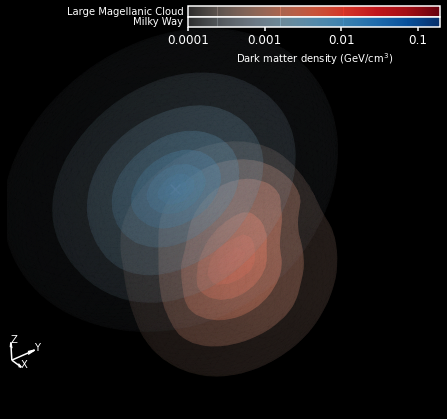

In [19]:
# read in the file

M = np.genfromtxt('MW_LMC_density_3d_2.txt',skip_header=1)

xsize = 71

XX = M[:,0].reshape([xsize,xsize,xsize])
YY = M[:,1].reshape([xsize,xsize,xsize])
ZZ = M[:,2].reshape([xsize,xsize,xsize])
DM = M[:,3].reshape([xsize,xsize,xsize]) # MW values
DL = M[:,4].reshape([xsize,xsize,xsize]) # LMC density values

# Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')


# make the figure
ls = LightSource(azdeg=90.0, altdeg=30.0)
lvls = 4
lvls = 8

# add contours for the MW and LMC
for indx,lval in enumerate(np.power(10.,np.linspace(-1.5,-4.,lvls))):
    
    try:
        verts, faces, normals, values = measure.marching_cubes_lewiner(DM, lval)
        mesh = Poly3DCollection(verts[faces])

        # Apply color to face
        rgbNew = make_rgb(normals,faces,ls,startcolor=cm.Blues_r(indx*(0.8/(lvls-1))))
        #rgbNew = make_rgb(normals,faces,ls,startcolor=cm.viridis(0.7))
        mesh.set_facecolor(rgbNew)
        mesh.set_alpha(0.04*(lvls-indx))

        ax.add_collection3d(mesh)
    except:
        pass


    try:
        verts, faces, normals, values = measure.marching_cubes_lewiner(DL, lval)
        mesh = Poly3DCollection(verts[faces])
    
        # Apply color to face
        rgbNew = make_rgb(normals,faces,ls,startcolor=cm.Reds_r(indx*(0.8/(lvls-1))))
        #rgbNew = make_rgb(normals,faces,ls,startcolor=cm.viridis(0.7))
        mesh.set_facecolor(rgbNew)
        mesh.set_alpha(0.09*(lvls-indx))

        ax.add_collection3d(mesh)
    except:
        pass


# zoom in to the inner third
minlim = int(0.333*xsize)
maxlim = int(0.6666*xsize)

ax.set_xlim(minlim,65)  
ax.set_ylim(minlim,maxlim)  
ax.set_zlim(minlim,maxlim) 

# make the background black
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

# set the camera angle
ax.view_init(elev=30., azim=-40.)

# colorbar machinery...
ax5 = fig.add_axes([0.5,0.9,0.35,0.02])

# plot the contours of the LMC dark matter halo
cmap = cm.Reds
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace( 0.1,1., cmap.N)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)


norm = mpl.colors.Normalize(vmin=0., vmax=2.)
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=my_cmap,norm=norm,orientation='horizontal')
#cb1.set_label('dark matter density (M$_\odot$/pc$^3$)',size=10,color='white')
cb1.ax.minorticks_off()
cb1.set_ticks([])
ax5.tick_params(axis='x', colors='white')
ax5.set_facecolor('black')
cb1.patch.set_facecolor((0,0,0,1))
cb1.outline.set_edgecolor('white')

ax5.text(-0.02,0.5,'Large Magellanic Cloud',ha='right',va='center',transform=ax5.transAxes,color='white')

ax6 = fig.add_axes([0.5,0.88,0.35,0.02])

# plot the contours of the Milky Way dark matter halo
cmap = cm.Blues
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0.1, 1., cmap.N)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(my_cmap)


norm = mpl.colors.Normalize(vmin=-4., vmax=-1.8)
cb1 = mpl.colorbar.ColorbarBase(ax6, cmap=my_cmap,norm=norm,orientation='horizontal')
#cb1.set_label('dark matter density (M$_\odot$/pc$^3$)',size=10,color='white')
cb1.set_label('Dark matter density (GeV/cm$^3$)',size=10,color='white')
cb1.ax.minorticks_off()

# convert the ticks to be in GeV/cm^3, even though the density is in Msun/pc^3
cb1.set_ticks([-4,-3.333,-2.666,-2])
cb1.set_ticklabels([0.0001,0.001,0.01,0.1])
ax6.tick_params(axis='x', colors='white')
ax6.tick_params(axis='both', colors='white')
cb1.outline.set_edgecolor('white')
cb1.patch.set_facecolor((0,0,0,1)) # https://stackoverflow.com/questions/26851194/matplotlib-change-background-color-of-colorbar-when-using-transparent-colors
ax6.set_facecolor('black')

ax6.text(-0.02,0.5,'Milky Way',ha='right',va='center',transform=ax6.transAxes,color='white')

half = 71./2.
rscldisc = 300./80.

# vector indicators
X = half-np.array([13,13,13])*1.2
vecsize = 3
U = [ vecsize, 0, 0]
V = [ 0, vecsize, 0]
W = [ 0, 0, vecsize]

ax.quiver(X,X,X-10,U,V,W,color='white')
ax.text(X[0]+vecsize,X[0],X[0]-10,'X',size=10,color='white')
ax.text(X[0],X[0]+vecsize,X[0]-10,'Y',size=10,color='white')
ax.text(X[0],X[0],X[0]+vecsize-10,'Z',size=10,color='white')

ax.scatter([xsize/2.-rscldisc*0.07],[xsize/2.],[xsize/2.], color = 'white', s=100, marker="x", zorder=10000)


In [25]:

# annotation for the solar circle...can't even see this
#half = 71./2.
#rscldisc = 300./80.
#ax.scatter([xsize/2.-rscldisc*0.07],[xsize/2.],[xsize/2.],facecolor='None',edgecolor='white',marker='o',s=100,zorder=100000)


